In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.utils.convtools import compute_output_shape, conviter
import scipy as sp
from deepmeg.preprocessing.transforms import one_hot_encoder, one_hot_decoder


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()


/data/pt_02648/deepmeg/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


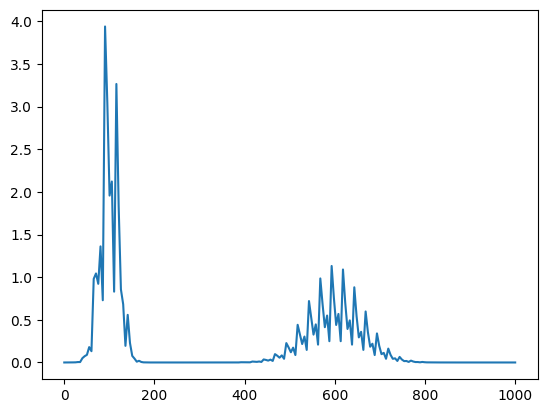

In [56]:
t = np.linspace(0, 1000, 200)

sig = lambda t, a, b: (
    np.exp(
            np.sin(t/2)
        ) + np.exp(
            np.sin(t)
        )
    ) * np.exp(
        -(t - a)**2 / (2 * b**2)
    )


plt.plot(t, sig(t, 100, 20) +  1/4*sig(t, 600, 60))
# plt.plot(t, sig(t, 200 + 2*np.random.randint(1, 40) - 40, 40) + -1 + 2*np.random.random((200)))

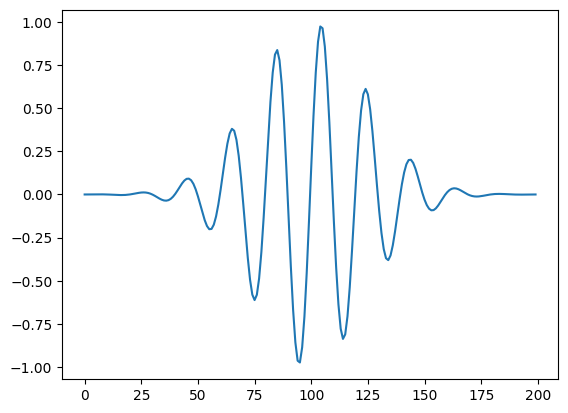

In [239]:
t = np.linspace(0, 200, 200)

sig = lambda t, a, b, f, phi=0: np.exp(
        -(t - a)**2 / (2 * b**2)
    ) * np.sin(2*np.pi*f*t + phi)


plt.plot(
    sig(t, 100, 25, 10)# + sig(t, 200, 50, 6)
)

In [272]:
# get_sig = lambda t, a, b: (
#     np.exp(
#         np.sin(t/2)
#     ) + np.exp(
#         np.sin(t)
#     )
# ) * np.exp(
#     -(t - a)**2 / (2 * b**2)
# )

get_sig = lambda t, a, b, f, phi=0: np.exp(
    -(t - a)**2 / (2 * b**2)
) * np.sin(2*np.pi*f*t + phi)

def gen_1d_source(n_epochs, n_times=1000, sfreq=200, lag=200, dlag=40, sigma=40, freqs=[10]):
    t = np.linspace(0, n_times, sfreq)
    freqs = [freqs] if isinstance(freqs, (int, float)) else freqs
    t2 = np.linspace(0, n_times//2, sfreq//2)
    waves = [get_sig(t2, lag, sigma, freq) for freq in freqs]
    X, Y = list(), list()

    for _ in range(n_epochs):
        dlag_ = np.random.randint(0, dlag)
        noise = -1 + 2*np.random.random((sfreq))
        sig = np.zeros(sfreq)

        for wave in waves:
            sig[dlag_: dlag_ + len(wave)] += wave

        X.append(sig + noise)
        Y.append(sig)

    return np.array(X), np.array(Y)

In [346]:
X, Y = gen_1d_source(500, dlag=20, freqs=[5, 40])
s = Y[0]

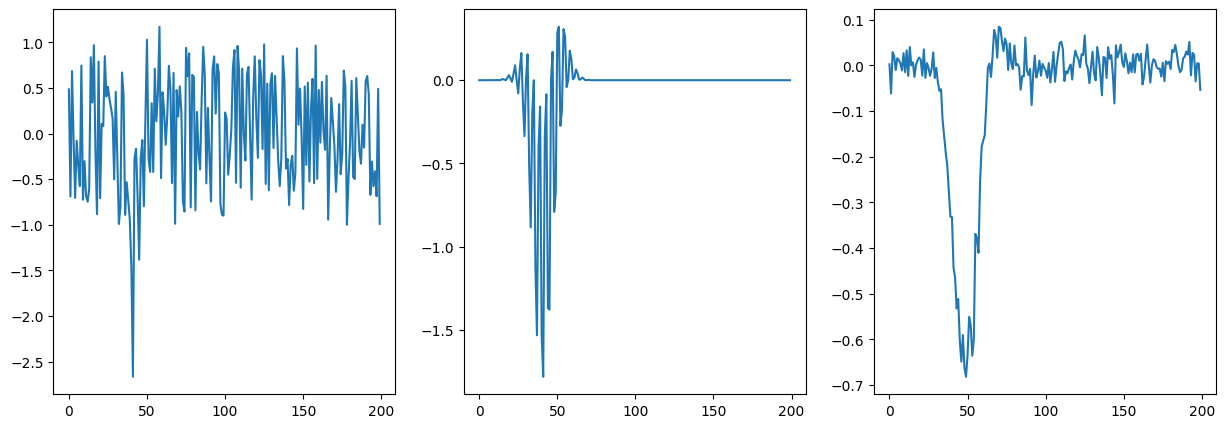

In [291]:
X, Y = gen_1d_source(500, dlag=20, freqs=[5, 40])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(X[0])
ax2.plot(Y[0])
ax3.plot(X.mean(0))

In [292]:

X = np.expand_dims(X, 1)
noise = 2*np.random.random(X.shape) - 1

In [305]:
Y = np.expand_dims(np.concatenate([np.zeros(len(X)), np.ones(len(noise))], 0), 1)
data = np.concatenate((X, noise), 0)

In [306]:
dataset = EpochsDataset((data, Y), transform=zscore, savepath='../datasets/sim_&_noise_1ch')
dataset.save('../data/sim_&_noise_1ch.pt')

In [ ]:
dataset = EpochsDataset.load('../data/sim_&_noise_1ch.pt')

In [307]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [308]:
x, y = next(iter(DataLoader(train, len(train))))
labels = np.squeeze(y)

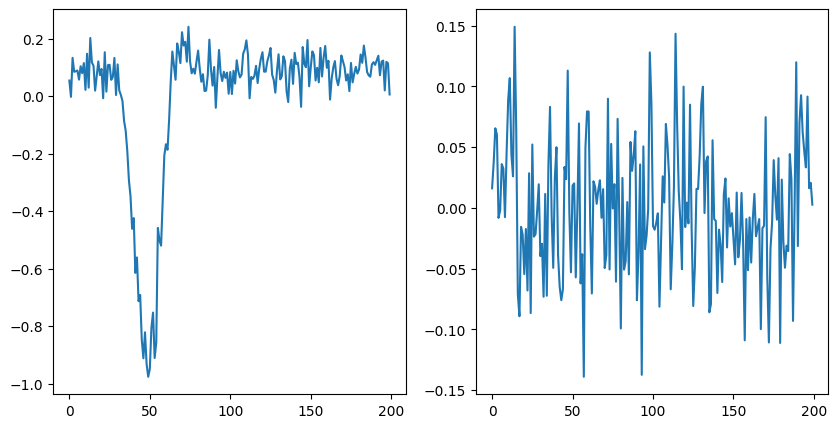

In [310]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(x[np.where(labels == 0)].mean(0).T)
ax2.plot(x[np.where(labels == 1)].mean(0).T)

In [320]:
from deepmeg.models.interpretable import LFCNN
from deepmeg.experimental.models import LFCNNW

disc = LFCNNW(
    n_channels=x.shape[1],
    n_times=x.shape[2],
    n_latent=1,
    filter_size=50,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

optimizer = torch.optim.Adam

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
disc.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)

In [ ]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

  0%|          | 0/150 [00:00<?, ?it/s]

/data/pt_02648/deepmeg/venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0:  loss_train:  0.7044   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7025   |    binary_accuracy_val:  0.5173
Epoch 1:  loss_train:  0.7042   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7025   |    binary_accuracy_val:  0.5173
Epoch 2:  loss_train:  0.7041   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7024   |    binary_accuracy_val:  0.5173
Epoch 3:  loss_train:  0.7039   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7024   |    binary_accuracy_val:  0.5173
Epoch 4:  loss_train:  0.7037   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7023   |    binary_accuracy_val:  0.5173
Epoch 5:  loss_train:  0.7035   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7022   |    binary_accuracy_val:  0.5173
Epoch 6:  loss_train:  0.7033   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7021   |    binary_accuracy_val:  0.5173
Epoch 7:  loss_train:  0.7031   |    binary_accuracy_train:  0.5010   |    loss_val:  0.7020   | 

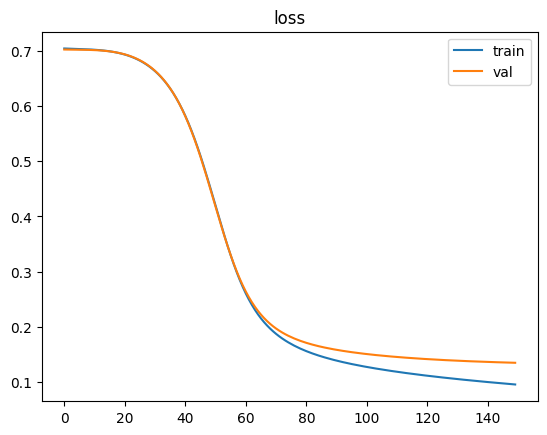

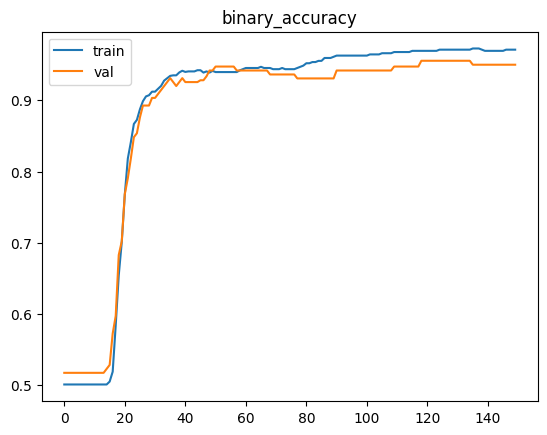

In [321]:
history = disc.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [322]:
train_result = disc.evaluate(train)
result = disc.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.10749574527144432
train_binary_accuracy: 0.9642857015132904
loss: 0.14202486723661423
binary_accuracy: 0.95333331823349


In [329]:
from deepmeg.training.trainers import Trainer


from collections import defaultdict
import sys
from typing import Any, Callable, Iterator, Optional, Sequence
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from deepmeg.utils.printout import nostdout


class GANTrainer(Trainer):

    def __init__(
        self, discriminator: nn.Module, generator: nn.Module,
        optimizers: tuple[torch.optim.Optimizer, torch.optim.Optimizer],
        criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        device: str, metric_functions: list[tuple[str, Callable[[torch.Tensor, torch.Tensor], torch.Tensor]]] = None,
        epoch_number: int = 0,
        lr_scheduler: Optional[Any] = None,
        callbacks: Callback | list[Callback] = None
    ):
        self.discriminator = discriminator
        self.generator = generator
        self.disc_optimizer, self.gen_optimizer = optimizers
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.discriminator.to(self.device)
        self.generator.to(self.device)

        if metric_functions and not isinstance(metric_functions, Sequence):
            metric_functions = [metric_functions]

        self.metric_functions = metric_functions if metric_functions else list()
        self.epoch_number = epoch_number
        self._interrupt = False

        if callbacks:
            if isinstance(callbacks, Callback):
                callbacks.set_trainer(self)
                self.callbacks = [callbacks]
            elif isinstance(callbacks, Sequence):
                for callback in callbacks:
                    callback.set_trainer(self)

                self.callbacks = callbacks
            else:
                raise ValueError(f'Callbacks must be either Sequence or Callback instance, instead {type(callbacks)} is given')
        else:
            self.callbacks = callbacks

    def get_disc_loss(self, xs_0: torch.Tensor, xs_1: torch.Tensor):
        xs_modified = self.generator(xs_0)
        y_pred_sig = self.discriminator(xs_modified)
        y_pred_noise = self.discriminator(xs_1)
        noise = torch.ones_like(y_pred_noise)
        sig = torch.zeros_like(y_pred_sig)
        y_true = torch.concat((noise, sig), 0)
        y_pred = torch.concat((y_pred_sig, y_pred_noise), 0)

        return self.criterion(y_pred, y_true)

    def get_gen_loss(self, xs_0, xs_1):
        xs_modified = self.generator(xs_0)
        xs_modified = torch.permute(xs_modified, (0, 2, 1))
        xs_modified = torch.reshape(xs_modified, (xs_modified.shape[0]*xs_modified.shape[1], xs_modified.shape[-1]))

        s = self.generator.temp_sel.b

        # return torch.norm((torch.cov(xs_modified.T)@self.discriminator.unmixing_layer.weight[:, :, 0].T), p=1) + torch.norm(s**2, p=1)
        return torch.norm((torch.cov(xs_modified.T)*self.discriminator.unmixing_layer.weight[:, :, 0].T), p=1) + torch.norm(s**2, p=1)

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[dict[str, float]]:
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):

            try:
                xs, ys_true = next(val_iterator)

                xs = xs.to(self.device)
                ys_true = ys_true.to(self.device)

                if self.callbacks:
                    for callback in self.callbacks:
                        callback.on_batch_begin(xs, ys_true)
                        callback.on_eval_batch_begin(xs, ys_true)
                if self._interrupt:
                    break
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.discriminator(self.generator(xs))
            # y_decoded = one_hot_decoder(ys_true.detach())
            y_decoded = torch.squeeze(ys_true.detach())
            xs_1 = xs[np.where(y_decoded == 1)]
            xs_0 = xs[np.where(y_decoded == 0)]

            self.generator.eval()
            self.discriminator.eval()
            disc_loss = self.get_disc_loss(xs_0, xs_1)
            gen_loss = self.get_gen_loss(xs_0, xs_1)

            if self.callbacks:
                for callback in self.callbacks:
                    new_losses = callback.on_loss_computed(xs, ys_true, None, (disc_loss, gen_loss))

                    if new_losses is not None:
                        disc_loss, gen_loss = new_losses

            losses.append(np.array([gen_loss.item(), disc_loss.item()]))

            predictions.append(ys_pred.to(self.device))
            targets.append(ys_true.to(self.device))

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)
        losses = np.array(losses)
        mean_gen_loss, mean_disc_loss = losses.mean(0)
        metrics = {'disc_loss': mean_disc_loss, 'gen_loss': mean_gen_loss}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_batch_end(targets, predictions, metrics)
                callback.on_eval_batch_end(targets, predictions, metrics)

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader, eval_on_n_batches: int = 1) -> dict[str, float]:
        self.interrupt(False)
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_evaluate_begin()

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None or self._interrupt:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_evaluate_end(metrics)

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[dict[str, float]]:
        self.disc_optimizer.zero_grad()
        self.gen_optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):

            try:
                xs, ys_true = next(train_iterator)

                xs = xs.to(self.device)
                ys_true = ys_true.to(self.device)

                if self.callbacks:
                    for callback in self.callbacks:
                        callback.on_batch_begin(xs, ys_true)
                        callback.on_train_batch_begin(xs, ys_true)

                if self._interrupt:
                    raise StopIteration
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.discriminator(self.generator(xs))
            # y_decoded = one_hot_decoder(ys_true.detach())
            y_decoded = torch.squeeze(ys_true.detach())
            xs_1 = xs[np.where(y_decoded == 1)]
            xs_0 = xs[np.where(y_decoded == 0)]

            self.generator.train()
            self.discriminator.train()
            disc_loss = self.get_disc_loss(xs_0, xs_1)
            gen_loss = self.get_gen_loss(xs_0, xs_1)

            if self.callbacks:
                for callback in self.callbacks:
                    new_losses = callback.on_loss_computed(xs, ys_true, None, (disc_loss, gen_loss))

                    if new_losses is not None:
                        disc_loss, gen_loss = new_losses

            (disc_loss / update_every_n_batches).backward()
            (gen_loss / update_every_n_batches).backward()
            losses.append(np.array([gen_loss.item(), disc_loss.item()]))

            predictions.append(ys_pred.to(self.device))
            targets.append(ys_true.to(self.device))

        self.gen_optimizer.step()
        self.disc_optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)
        losses = np.array(losses)
        mean_gen_loss, mean_disc_loss = losses.mean(0)
        metrics = {'disc_loss': mean_disc_loss, 'gen_loss': mean_gen_loss}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_batch_end(targets, predictions, metrics)
                callback.on_train_batch_end(targets, predictions, metrics)

        return metrics

    def fit_epoch(self, train_loader: DataLoader, update_every_n_batches: int = 1) -> dict[str, float]:

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None or self._interrupt:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader: DataLoader, num_epochs: int,
            val_loader: DataLoader = None, update_every_n_batches: int = 1,
            eval_on_n_batches: int = 1, eval_every_n_epochs: int = 1,
            ) -> dict[str, np.ndarray]:

        self.interrupt(False)

        summary = defaultdict(list)

        def save_metrics(metrics: dict[str, float], postfix: str = '') -> None:
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)
        import traceback
        try:
            for i in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs, file=sys.stdout):
                with nostdout():

                    self.epoch_number += 1

                    if self._interrupt:
                        print(f'The training loop was completed at epoch {self.epoch_number} due to an interruption')
                        self.interrupt(False)
                        break

                    if self.callbacks:
                        for callback in self.callbacks:
                            callback.on_epoch_begin(i)

                    train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

                    train_metrics = {f'{key}_train': value for key, value in train_metrics.items()}
                    val_metrics = False

                    with torch.no_grad():
                        save_metrics(train_metrics)

                        if val_loader is not None and not i%eval_every_n_epochs:
                            val_metrics = self.evaluate(val_loader, eval_on_n_batches)
                            val_metrics = {f'{key}_val': value for key, value in val_metrics.items()}
                            save_metrics(val_metrics)

                    if self.callbacks:
                        for callback in self.callbacks:
                            all_metrics = train_metrics | val_metrics if val_metrics else train_metrics
                            callback.on_epoch_end(i, all_metrics)

                    if self.lr_scheduler is not None:
                        self.lr_scheduler.step()

            summary = {metric: np.array(summary[metric]) for metric in summary}

            return summary
        except Exception as e:
            print(e)
            traceback.print_exc()
            self.interrupt()


In [318]:
from deepmeg.models import BaseModel
import torch.nn as nn


def heaviside(x, k=20):
    return 1/(1e-7 + 1 + torch.exp(-2*k*x))


class BB(nn.Module):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.b = nn.Parameter(torch.empty(n_channels, n_times))
        self.bn = nn.BatchNorm1d(n_channels)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.uniform_(self.b, -1e-7, 1e-7)

    def forward(self, x):
        x = self.bn(x)
        return x - self.b


class LFGen(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        filter_size: int,
    ):
        super().__init__()
        self.n_channels = n_channels
        self.temp_sel = BB(n_channels, n_times)


    def forward(self, x: torch.Tensor):
        x = self.temp_sel(x)
        return x

X = torch.rand((1, 64, 600))

LFGen(64, 600, 50)(X)

tensor([[[ 1.0224, -1.2715,  1.6294,  ...,  0.5803,  0.5569, -1.0757],
         [ 0.9805, -1.2388,  1.5739,  ...,  1.0412,  0.6432,  0.4758],
         [-0.1495,  0.8144,  0.9212,  ..., -0.9327, -1.7351, -1.5420],
         ...,
         [ 1.0740, -0.9417, -0.4180,  ...,  0.9467,  1.3207,  1.1979],
         [ 1.0066, -0.6189,  1.2467,  ...,  1.1054,  0.6906, -0.4690],
         [ 1.1383,  0.1774,  1.3578,  ..., -1.4711, -1.3885, -1.2440]]],
       grad_fn=<SubBackward0>)

In [336]:
from deepmeg.training.callbacks import Callback
from deepmeg.training.trainers import Trainer

class PowerAndNoiseCallback(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.generator = self.trainer.generator
        self.discriminator = self.trainer.discriminator

    def on_batch_begin(
        self,
        X: torch.Tensor,
        Y: torch.Tensor
    ):
        xs_modified = self.generator(X)
        xs_modified = torch.permute(xs_modified, (0, 2, 1))
        xs_modified = torch.reshape(xs_modified, (xs_modified.shape[0]*xs_modified.shape[1], xs_modified.shape[-1]))
        self.x_mod = xs_modified

    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        metrics['noise'] = torch.norm((torch.cov(self.x_mod.T)*self.discriminator.unmixing_layer.weight[:, :, 0].T), p=1)
        # metrics['noise'] = torch.norm((torch.cov(self.x_mod.T)@self.discriminator.unmixing_layer.weight[:, :, 0].T), p=1)
        # metrics['noise'] = torch.norm(self.x_mod@self.discriminator.unmixing_layer.weight[:, :, 0].T, 1)
        metrics['power'] = torch.norm(self.generator.temp_sel.b**2, p=1)


class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)

class TempWeightsZeroMean(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.generator = self.trainer.generator
        self.discriminator = self.trainer.discriminator
        self.clipper = WeightClipper(self.generator)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.generator.apply(self.clipper)



from deepmeg.training.callbacks import L1Reg
class L1RegGen(L1Reg):

    def set_trainer(self, trainer: 'Trainer'):
        self.trainer = trainer
        self.model = self.trainer.generator

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            gen_loss += lambda_*torch.norm(state_dict[layer_name], 1)

        return disc_loss, gen_loss


class L2RegGen(L1RegGen):

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            gen_loss += lambda_*torch.norm(state_dict[layer_name], 2)

        return disc_loss, gen_loss


class L1RegDisc(L1Reg):

    def set_trainer(self, trainer: 'Trainer'):
        self.trainer = trainer
        self.model = self.trainer.discriminator

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            disc_loss += lambda_*torch.norm(state_dict[layer_name], 1)

        return disc_loss, gen_loss

class L2RegDisc(L1RegDisc):

    def on_loss_computed(self, X, Y, Y_pred, loss):
        state_dict = self.model.state_dict()
        disc_loss, gen_loss = loss

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            disc_loss += lambda_*torch.norm(state_dict[layer_name], 2)

        return disc_loss, gen_loss

In [340]:
from deepmeg.experimental.models import LFCNNW
from deepmeg.models.interpretable import LFCNN

gen = LFGen(
    n_channels=x.shape[1],
    n_times=x.shape[2],
    filter_size=50
)

disc = LFCNNW(
    n_channels=x.shape[1],
    n_times=x.shape[2],
    n_latent=1,
    filter_size=50,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

disc_optimizer = torch.optim.Adam(disc.parameters())
gen_optimizer = torch.optim.Adam(gen.parameters())

loss = torch.nn.BCEWithLogitsLoss()
# loss = earth_mover_distance
metric = torchmetrics.functional.classification.binary_accuracy

trainer = GANTrainer(
    disc,
    gen,
    (disc_optimizer, gen_optimizer),
    loss,
    'cpu',
    BaseModel._validate_metrics(metric),
    callbacks = [
        PrintingCallback(),
        PowerAndNoiseCallback(),
        # TempWeightsZeroMean(),
        L2RegDisc(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ),
        L2RegGen(
            [
                'temp_sel.b'
            ], lambdas=.01
        )
    ]
)


In [352]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [353]:
n_epochs=1500
batch_size=200
val_batch_size=60
train_loader, val_loader = BaseModel._prepare_dataloaders(train, batch_size, None, val_batch_size)
history = trainer.fit(train_loader, n_epochs, val_loader, update_every_n_batches=1, eval_on_n_batches=1, eval_every_n_epochs=1)
plot_metrics(history)

Epoch 0:  disc_loss_train:  0.3176   |    gen_loss_train:  0.1357   |    binary_accuracy_train:  0.4837   |    noise_train:  0.1355   |    power_train:  0.0000   |    disc_loss_val:  0.3569   |    gen_loss_val:  0.1350   |    binary_accuracy_val:  0.5148   |    noise_val:  0.1349   |    power_val:  0.0001
Epoch 1:  disc_loss_train:  0.3170   |    gen_loss_train:  0.1348   |    binary_accuracy_train:  0.4853   |    noise_train:  0.1345   |    power_train:  0.0001   |    disc_loss_val:  0.3550   |    gen_loss_val:  0.1343   |    binary_accuracy_val:  0.5148   |    noise_val:  0.1340   |    power_val:  0.0001
Epoch 2:  disc_loss_train:  0.3161   |    gen_loss_train:  0.1340   |    binary_accuracy_train:  0.4870   |    noise_train:  0.1336   |    power_train:  0.0002   |    disc_loss_val:  0.3526   |    gen_loss_val:  0.1335   |    binary_accuracy_val:  0.5148   |    noise_val:  0.1331   |    power_val:  0.0002
Epoch 3:  disc_loss_train:  0.3150   |    gen_loss_train:  0.1333   |    binary

KeyboardInterrupt: 

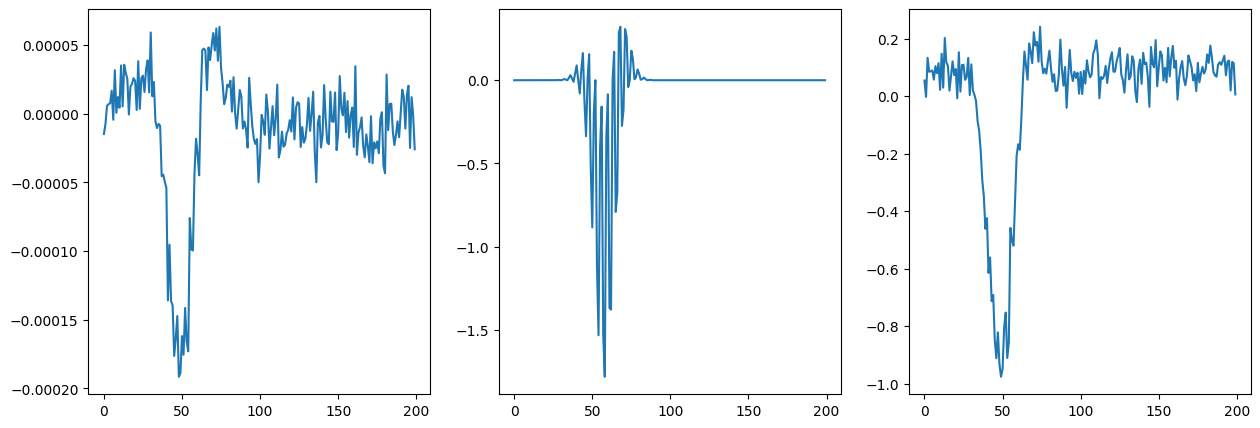

In [354]:
x, y = next(iter(DataLoader(train, len(train))))
labels = np.squeeze(y)
weights = gen.temp_sel.b.detach().numpy()
# weights = gen.temp_sel.w.detach().numpy()*gen.temp_sel.b.detach().numpy()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(weights.T)
ax2.plot(s)
r = ax3.plot(x[np.where(labels == 0)].mean(0).T)